In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)
import os
os.environ['PATH'] = '/opt/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']

2024-10-18 14:42:11.844622: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-18 14:42:11.860906: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-18 14:42:12.011262: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-18 14:42:12.011327: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-18 14:42:12.041789: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
data = fetch_openml('hls4ml_lhc_jets_hlf')
X, y = data['data'], data['target']

/home/donovan/miniconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
print(data['feature_names'])
print(X.shape, y.shape)
print(X[:5])
print(y[:5])

['zlogz', 'c1_b0_mmdt', 'c1_b1_mmdt', 'c1_b2_mmdt', 'c2_b1_mmdt', 'c2_b2_mmdt', 'd2_b1_mmdt', 'd2_b2_mmdt', 'd2_a1_b1_mmdt', 'd2_a1_b2_mmdt', 'm2_b1_mmdt', 'm2_b2_mmdt', 'n2_b1_mmdt', 'n2_b2_mmdt', 'mass_mmdt', 'multiplicity']
(830000, 16) (830000,)
      zlogz  c1_b0_mmdt  c1_b1_mmdt  c1_b2_mmdt  c2_b1_mmdt  c2_b2_mmdt  \
0 -2.935125    0.383155    0.005126    0.000084    0.009070    0.000179   
1 -1.927335    0.270699    0.001585    0.000011    0.003232    0.000029   
2 -3.112147    0.458171    0.097914    0.028588    0.124278    0.038487   
3 -2.666515    0.437068    0.049122    0.007978    0.047477    0.004802   
4 -2.484843    0.428981    0.041786    0.006110    0.023066    0.001123   

   d2_b1_mmdt  d2_b2_mmdt  d2_a1_b1_mmdt  d2_a1_b2_mmdt  m2_b1_mmdt  \
0    1.769445    2.123898       1.769445       0.308185    0.135687   
1    2.038834    2.563099       2.038834       0.211886    0.063729   
2    1.269254    1.346238       1.269254       0.246488    0.115636   
3    0.966505  

In [4]:
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y, 5)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(y[:5])

[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]


In [5]:
scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)

In [6]:
np.save('X_train_val.npy', X_train_val)
np.save('X_test.npy', X_test)
np.save('y_train_val.npy', y_train_val)
np.save('y_test.npy', y_test)
np.save('classes.npy', le.classes_)

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.models import load_model
# from callbacks import all_callbacks

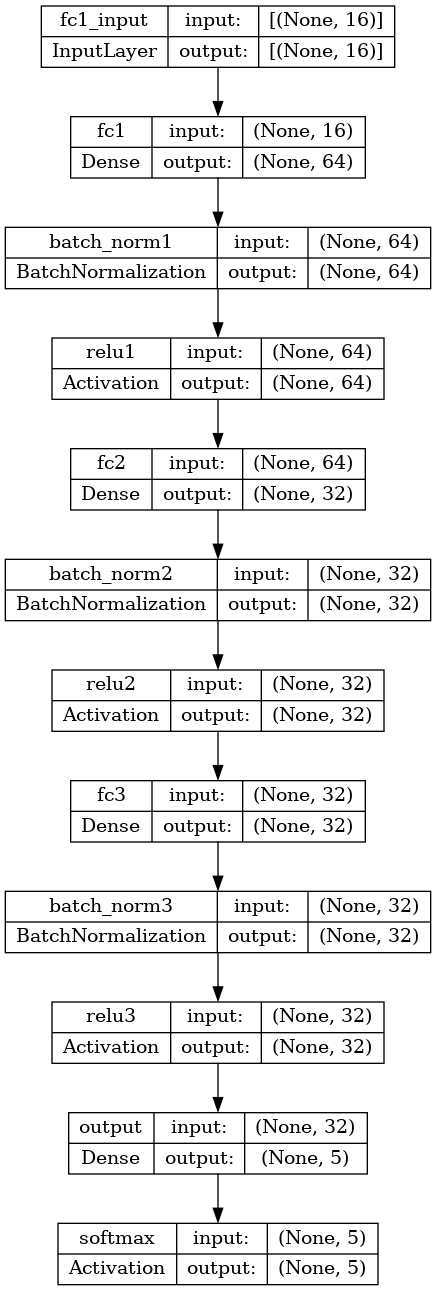

In [12]:
# from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import plot_model
model = load_model('model.h5', compile=False)
plot_model(model, show_shapes=True, show_layer_names=True)

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: Input
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: batch_norm1, layer type: BatchNormalization
Layer name: relu1, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: batch_norm2, layer type: BatchNormalization
Layer name: relu2, layer type: Activation
Layer name: fc3, layer type: Dense
  -> Activation (linear), layer name: fc3
Layer name: batch_norm3, layer type: BatchNormalization
Layer name: relu3, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: softmax, layer type: Activation
-----------------------------------
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 64]
Layer name: ba

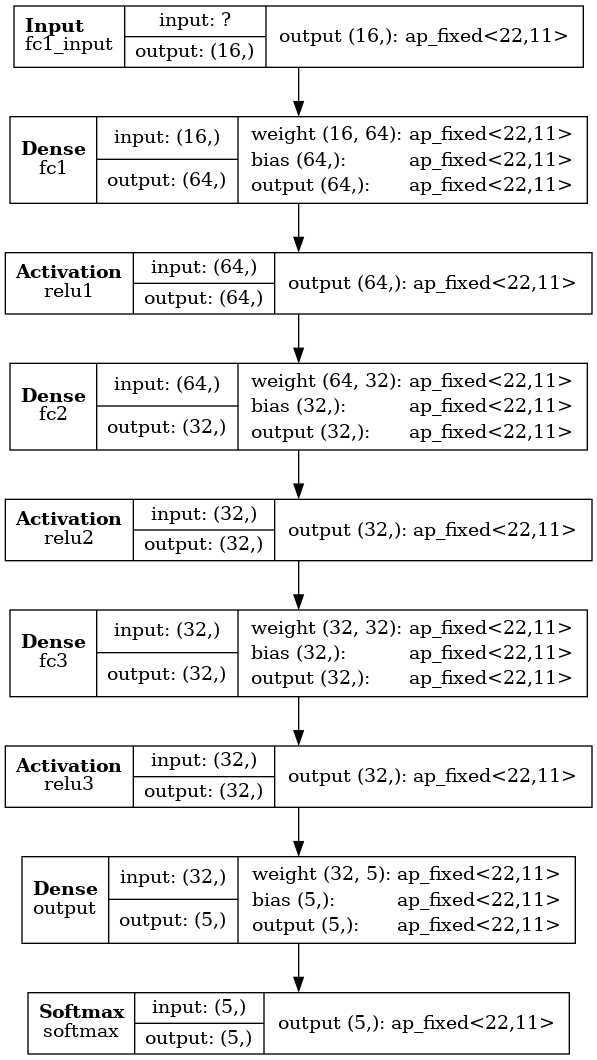

In [36]:
import hls4ml
config = hls4ml.utils.config_from_keras_model(model, granularity='model')
config['Model']['Precision'] = 'ap_fixed<22,11>'
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                       hls_config=config,
                                                       output_dir='model_4/hls4ml_prj',
                                                       part='xcu280-fsvh2892-2L-e')
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

In [37]:
hls_model.compile()

Writing HLS project
Done


In [38]:
hls_model.build(csim=False)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.1 (64-bit)
  **** SW Build 2552052 on Fri May 24 14:47:09 MDT 2019
  **** IP Build 2548770 on Fri May 24 18:01:18 MDT 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /tools/Xilinx/Vivado/2019.1/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/tools/Xilinx/Vivado/2019.1/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'waiz' on host 'Obsidian.localdomain' (Linux_x86_64 version 5.10.16.3-microsoft-standard-WSL2) on Wed Jan 31 14:08:55 PST 2024
INFO: [HLS 200-10] On os Ubuntu 22.04.1 LTS
INFO: [HLS 200-10] In directory '/home/waiz/hls4ml-tutorial/model_4/hls4ml_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/home/waiz/hls4ml-tutorial/model_4/hls4ml_prj/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject.cpp' to the project
INFO: [HLS 200-10] Adding test bench file 'myproject_test.cpp' to the project
INFO: [HL

INFO: [HLS 200-111] Finished Checking Synthesizability Time (s): cpu = 00:00:13 ; elapsed = 00:00:13 . Memory (MB): peak = 952.340 ; gain = 266.238 ; free physical = 22568 ; free virtual = 31437
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::softmax_latency<ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, softmax_config16>' (firmware/nnet_utils/nnet_activation.h:224:45).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::init_exp_table<ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, softmax_config16>' (firmware/nnet_utils/nnet_activation.h:204:48).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::dense_latency<ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, config14>' (firmware/nnet_utils/nnet_dense_latency.h:39:55).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::relu<ap_fixed<22

INFO: [HLS 200-489] Unrolling loop 'Loop-1' (firmware/nnet_utils/nnet_activation.h:76) in function 'nnet::relu<ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, relu_config5>' completely with a factor of 64.
INFO: [HLS 200-489] Unrolling loop 'Product1' (firmware/nnet_utils/nnet_dense_latency.h:85) in function 'nnet::dense_latency<ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'Product2' (firmware/nnet_utils/nnet_dense_latency.h:90) in function 'nnet::dense_latency<ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>' completely with a factor of 64.
INFO: [HLS 200-489] Unrolling loop 'ResetAccum' (firmware/nnet_utils/nnet_dense_latency.h:101) in function 'nnet::dense_latency<ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<22, 11, (ap_q_mode)5, (ap_o_

INFO: [XFORM 203-602] Inlining function 'nnet::Op_add<ap_fixed<18, 8, (ap_q_mode)5, (ap_o_mode)3, 0> >::operator()' into 'nnet::reduce<ap_fixed<18, 8, (ap_q_mode)5, (ap_o_mode)3, 0>, 2, nnet::Op_add<ap_fixed<18, 8, (ap_q_mode)5, (ap_o_mode)3, 0> > >' (firmware/nnet_utils/nnet_common.h:53) automatically.
INFO: [XFORM 203-602] Inlining function 'nnet::reduce<ap_fixed<18, 8, (ap_q_mode)5, (ap_o_mode)3, 0>, 2, nnet::Op_add<ap_fixed<18, 8, (ap_q_mode)5, (ap_o_mode)3, 0> > >' into 'nnet::reduce<ap_fixed<18, 8, (ap_q_mode)5, (ap_o_mode)3, 0>, 4, nnet::Op_add<ap_fixed<18, 8, (ap_q_mode)5, (ap_o_mode)3, 0> > >' (firmware/nnet_utils/nnet_common.h:55) automatically.
INFO: [XFORM 203-602] Inlining function 'nnet::Op_add<ap_fixed<18, 8, (ap_q_mode)5, (ap_o_mode)3, 0> >::operator()' into 'nnet::reduce<ap_fixed<18, 8, (ap_q_mode)5, (ap_o_mode)3, 0>, 4, nnet::Op_add<ap_fixed<18, 8, (ap_q_mode)5, (ap_o_mode)3, 0> > >' (firmware/nnet_utils/nnet_common.h:55) automatically.
INFO: [XFORM 203-602] Inlining 

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, config10>.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:45:23) to 'nnet::dense_latency<ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, config10>.0.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_dense.h:46->firmware/myproject.cpp:80) by setting 'biases[6].V' to 'b10.V.6'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, config10>.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:45:23) to 'nnet::dense_latency<ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, config10>.0.0.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_dense.h:46->firmware/myproject.cpp:80) by setting 'biases[7].V' to '

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, config10>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:45:23) to 'nnet::dense_latency<ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, config10>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_dense.h:46->firmware/myproject.cpp:80) by setting 'biases[22].V' to 'b10.V.22'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, config10>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:45:23) to 'nnet::dense_latency<ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, config10>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:45:23) to 'nnet::dense_latency<ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_dense.h:46->firmware/myproject.cpp:72) by setting 'biases[4].V' to 'b6.V.4'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:45:23) to 'nnet::dense_latency<ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_dense.h:46->firmware/myproject.cpp:72) by setting 'biases[5].V' to 'b6.V.5'.
INFO: [XFORM

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:45:23) to 'nnet::dense_latency<ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_dense.h:46->firmware/myproject.cpp:72) by setting 'biases[20].V' to 'b6.V.20'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:45:23) to 'nnet::dense_latency<ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:45:23) to 'nnet::dense_latency<ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0' by setting 'biases[7].V' to 'b2.V.7'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:45:23) to 'nnet::dense_latency<ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0' by setting 'biases[8].V' to 'b2.V.8'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<22, 11, (ap_q_mode)5

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:45:23) to 'nnet::dense_latency<ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[31].V' to 'b2.V.31'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:45:23) to 'nnet::dense_latency<ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:45:23) to 'nnet::dense_latency<ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[47].V' to 'b2.V.47'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:45:23) to 'nnet::dense_latency<ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<22, 11, (a

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:45:23) to 'nnet::dense_latency<ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[63].V' to 'b2.V.63'.
INFO: [XFORM 203-401] Performing if-conversion on hyperblock to (firmware/nnet_utils/nnet_activation.h:190:20) in function 'nnet::softmax_real_val_from_idx<ap_fixed<22, 11, (ap_q_mode)5, (ap_o_mode)3, 0>, softmax_config16>'... converting 10 basic blocks.
INFO: [XFORM 203-401] Performing if-conversion on hyperblock from (firmware/nnet_utils/nnet_a

INTERNAL-INFO: never seen llvm instruction 'fexp'(507)
INTERNAL-INFO: never seen llvm instruction 'fexp'(507)
INTERNAL-INFO: never seen llvm instruction 'fexp'(507)
INTERNAL-INFO: never seen llvm instruction 'fexp'(507)
INTERNAL-INFO: never seen llvm instruction 'fexp'(507)
INTERNAL-INFO: never seen llvm instruction 'fexp'(507)
INTERNAL-INFO: never seen llvm instruction 'fexp'(507)
INTERNAL-INFO: never seen llvm instruction 'fexp'(507)
INTERNAL-INFO: never seen llvm instruction 'fexp'(507)
INTERNAL-INFO: never seen llvm instruction 'fexp'(507)
INTERNAL-INFO: never seen llvm instruction 'fexp'(507)
INTERNAL-INFO: never seen llvm instruction 'fexp'(507)
INTERNAL-INFO: never seen llvm instruction 'fexp'(507)
INTERNAL-INFO: never seen llvm instruction 'fexp'(507)
INTERNAL-INFO: never seen llvm instruction 'fexp'(507)
INTERNAL-INFO: never seen llvm instruction 'fexp'(507)
INTERNAL-INFO: never seen llvm instruction 'fexp'(507)
INTERNAL-INFO: never seen llvm instruction 'fexp'(507)
INFO: [HLS

INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.43 seconds; current allocated memory: 912.758 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'dense_latency_ap_fixed_ap_fixed_config14_0_0_0_0_0_0' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'dense_latency<ap_fixed,ap_fixed,config14>.0.0.0.0.0.0'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 2.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 0.7 seconds; current allocated memory: 915.234 MB.
INFO: [BIND 205-100] Startin

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'init_exp_table_ap_fixed_22_11_5_3_0_softmax_config16_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Generating core module 'myproject_fexp_32ns_32ns_32_8_full_dsp_1': 2 instance(s).
INFO: [RTGEN 206-100] Generating core module 'myproject_fpext_32ns_64_2_1': 2 instance(s).
INFO: [RTGEN 206-100] Finished creating RTL model for 'init_exp_table_ap_fixed_22_11_5_3_0_softmax_config16_s'.
INFO: [HLS 200-111]  Elapsed time: 7.03 seconds; current allocated memory: 1.607 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'softmax_latency_ap_fixed_ap_fixed_softmax_config16_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SYN 201-210] Renamed object name 'softmax_latency_ap_fi

{'EstimatedClockPeriod': '4.372',
 'BestLatency': '525',
 'WorstLatency': '525',
 'IntervalMin': '526',
 'IntervalMax': '526',
 'BRAM_18K': '2',
 'DSP48E': '2894',
 'FF': '48426',
 'LUT': '345396',
 'URAM': '0',
 'AvailableBRAM_18K': '4032',
 'AvailableDSP48E': '9024',
 'AvailableFF': '2607360',
 'AvailableLUT': '1303680',
 'AvailableURAM': '960'}